# Comparing outputs between models of different Eureka iterations

## Intro
We have trajectories (observations, mu (mean actions), value (critic value)) of 3 models: 
weak (iter0), medium (iter1), strong (eval)

We want to study how these models (both actor and critic) differ from each other by:

### Experiment 1: How do weaker models perceive good scenarios?
Using the observations of strong model, run thru weaker models to get mu and value
We compare the mu and value of the weaker models with the strong model's mu and value

- come up with ideas: 
    - how to compare mu since its multi-dimensional?
    - how to measure how often deviations happen?

### Experiment 2: How does strong model perceive bad scenarios?
with weak model's observations, get strong model's mu and value 
compare with the weak model's own mu and value

## Data format
example data format of variables and their shapes:
```
pre_norm_obs
(499, 64, 23)
post_norm_obs
(499, 64, 23)
mu
(499, 64, 9)
logstd
(499, 64, 9)
value
(499, 64, 1)
```
where the dimensions indicate (time, batch, actual_dim)

## Visualization
we can fix an index within the batch and plot the time series of various variables/dimensions.
Use matplotlib

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
WEAK_MODEL_FILE = "FrankaCabinetGPT_epoch__iter0.pth"
MEDIUM_MODEL_FILE = "FrankaCabinetGPT_epoch__iter1.pth"
STRONG_MODEL_FILE = "FrankaCabinetGPT_epoch__eval.pth"

CHECKPOINT_DIR = 'ckpts/2025-02-13_09-26-08'

In [3]:
from utils.model_utils import load_model, load_data, compute_model_outputs, process_model_outputs

In [4]:
# 1. Load all three models

weak_model = load_model(WEAK_MODEL_FILE, CHECKPOINT_DIR)
medium_model = load_model(MEDIUM_MODEL_FILE, CHECKPOINT_DIR)
strong_model = load_model(STRONG_MODEL_FILE, CHECKPOINT_DIR)

# 2. Load all trajectory data
weak_data = load_data(WEAK_MODEL_FILE, CHECKPOINT_DIR)
medium_data = load_data(MEDIUM_MODEL_FILE, CHECKPOINT_DIR)
strong_data = load_data(STRONG_MODEL_FILE, CHECKPOINT_DIR)

Loading model from: ckpts/2025-02-13_09-26-08/FrankaCabinetGPT_epoch__iter0_dill.pkl
Model loaded successfully! Type: Network
Loading model from: ckpts/2025-02-13_09-26-08/FrankaCabinetGPT_epoch__iter1_dill.pkl
Model loaded successfully! Type: Network
Loading model from: ckpts/2025-02-13_09-26-08/FrankaCabinetGPT_epoch__eval_dill.pkl
Model loaded successfully! Type: Network
Loading data from: ckpts/2025-02-13_09-26-08/FrankaCabinetGPT_epoch__iter0.npz
Loading data from: ckpts/2025-02-13_09-26-08/FrankaCabinetGPT_epoch__iter1.npz
Loading data from: ckpts/2025-02-13_09-26-08/FrankaCabinetGPT_epoch__eval.npz


In [4]:
print("\nLoaded data shapes:")
for name, data in [("Weak", weak_data), ("Medium", medium_data), ("Strong", strong_data)]:
    print(f"{name} model data:")
    for key in data.files:
        print(f"  {key}: {data[key].shape}")


Loaded data shapes:
Weak model data:
  pre_norm_obs: (499, 64, 23)
  post_norm_obs: (499, 64, 23)
  mu: (499, 64, 9)
  logstd: (499, 64, 9)
  value: (499, 64, 1)
Medium model data:
  pre_norm_obs: (499, 64, 23)
  post_norm_obs: (499, 64, 23)
  mu: (499, 64, 9)
  logstd: (499, 64, 9)
  value: (499, 64, 1)
Strong model data:
  pre_norm_obs: (58, 64, 23)
  post_norm_obs: (58, 64, 23)
  mu: (58, 64, 9)
  logstd: (58, 64, 9)
  value: (58, 64, 1)


In [28]:
def unwrap_data(data):
    return data['pre_norm_obs'], data['mu'], data['value']

In [29]:
obs_strong_original, mu_strong_original, value_strong_original = unwrap_data(strong_data)
obs_medium_original, mu_medium_original, value_medium_original = unwrap_data(medium_data)
obs_weak_original, mu_weak_original, value_weak_original = unwrap_data(weak_data)

In [30]:
mu_strong_original_clipped, value_strong_original_denorm = process_model_outputs(
    mu_strong_original, 
    value_strong_original, 
    strong_model,
)

In [31]:
mu_medium_original_clipped, value_medium_original_denorm = process_model_outputs(
    mu_medium_original, 
    value_medium_original, 
    medium_model
)

In [32]:
mu_weak_original_clipped, value_weak_original_denorm = process_model_outputs(
    mu_weak_original, 
    value_weak_original, 
    weak_model
)

In [33]:
clipped_mu_list = [
    mu_strong_original_clipped, 
    mu_medium_original_clipped, 
    mu_weak_original_clipped
]

In [43]:
obs_list = [
    obs_strong_original,
    obs_medium_original,
    obs_weak_original
]

In [34]:
labels = ["Strong", "Medium", "Weak"]

In [60]:
from utils.data_transforms import get_all_phase_masks, segment_observation

In [57]:
joint_positions, joint_velocities, rel_pos_to_handle, drawer_position, drawer_velocity = segment_observation(obs_strong_original)

In [58]:
approaching_mask, approaching_count, opening_mask, opening_count, deceleration_mask, deceleration_count = get_all_phase_masks(drawer_position, drawer_velocity)

## Experiment 1: Strong model's observations on other models
TODO: plot_action_trajectories has changed, update params

In [6]:
# Run other models on strong observations
mu_medium_strong_obs, value_medium_strong_obs, _ = compute_model_outputs(
    medium_model, 
    obs_strong_original, 
    mu_strong_original, 
    value_strong_original
)

mu_weak_strong_obs, value_weak_strong_obs, _ = compute_model_outputs(
    weak_model, 
    obs_strong_original, 
    mu_strong_original, 
    value_strong_original
)

In [7]:
# Extract and transform outputs before comparison
mu_medium_strong_obs_clipped, value_medium_strong_obs_denorm = process_model_outputs(
    mu_medium_strong_obs, 
    value_medium_strong_obs, 
    medium_model,
)

mu_weak_strong_obs_clipped, value_weak_strong_obs_denorm = process_model_outputs(
    mu_weak_strong_obs, 
    value_weak_strong_obs, 
    weak_model,
)

In [8]:
from utils.plots import plot_action_heatmap, plot_action_trajectories, plot_action_magnitudes, plot_value_comparison, plot_value_vs_action

In [22]:
# Choose a batch index to visualize (e.g., 0)
batch_idx = 0
actor_idx = batch_idx

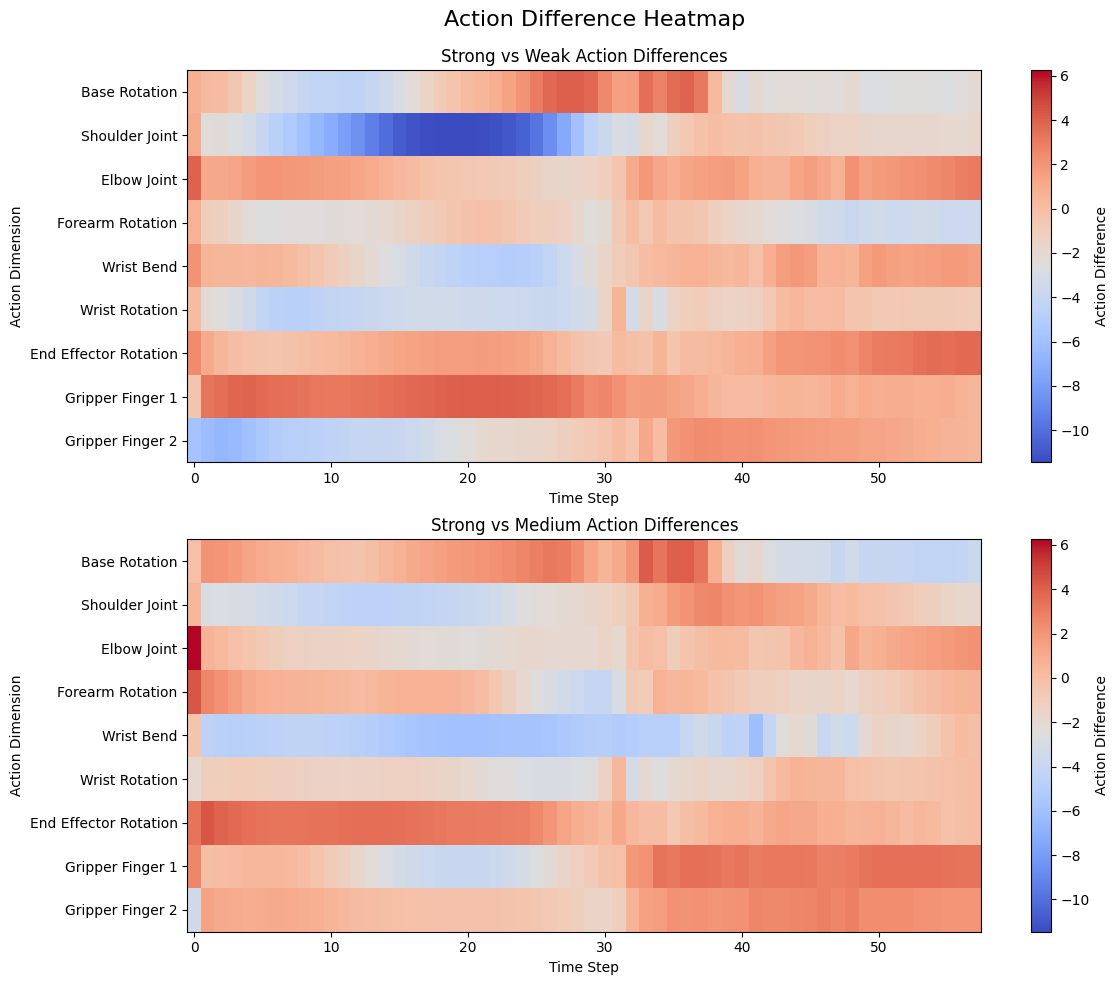

In [10]:
# 1. Action Dimension Heatmaps
plot_action_heatmap(mu_strong_original, mu_weak_strong_obs, mu_medium_strong_obs, batch_idx)

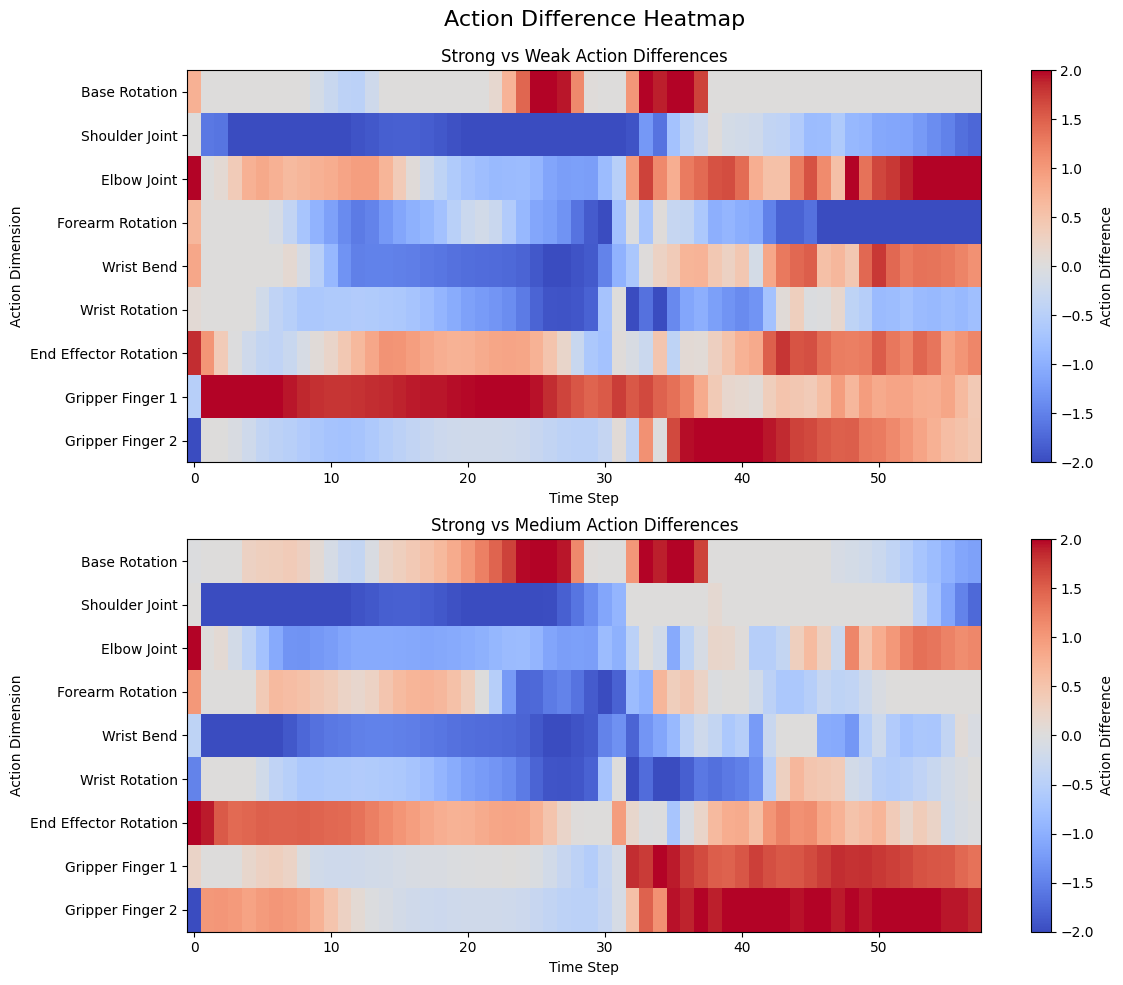

In [11]:
plot_action_heatmap(
    mu_strong_original_clipped, 
    mu_weak_strong_obs_clipped, 
    mu_medium_strong_obs_clipped, 
    batch_idx
)

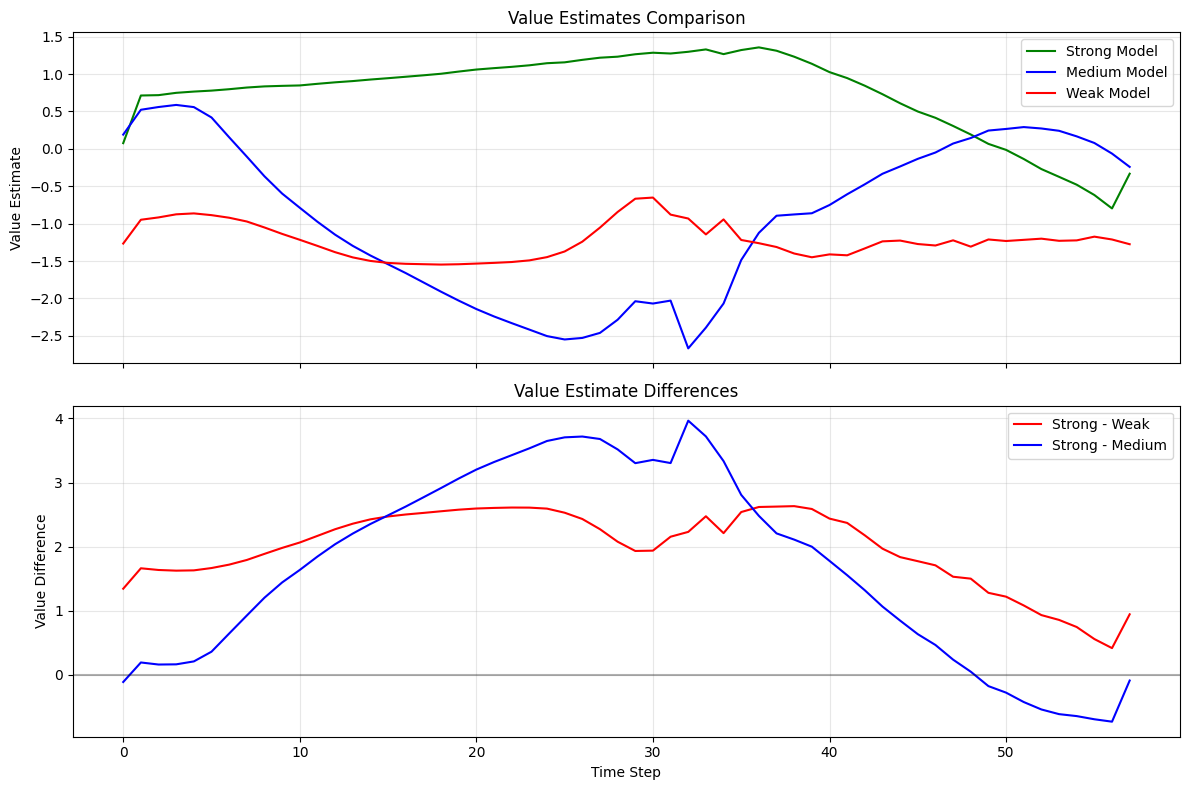

In [13]:
# Value Comparison Plot, dont denorm
plot_value_comparison(value_strong_original, value_weak_strong_obs, value_medium_strong_obs, batch_idx)

In [24]:
strong_obs_mu_list = [mu_strong_original, mu_medium_strong_obs, mu_weak_strong_obs]

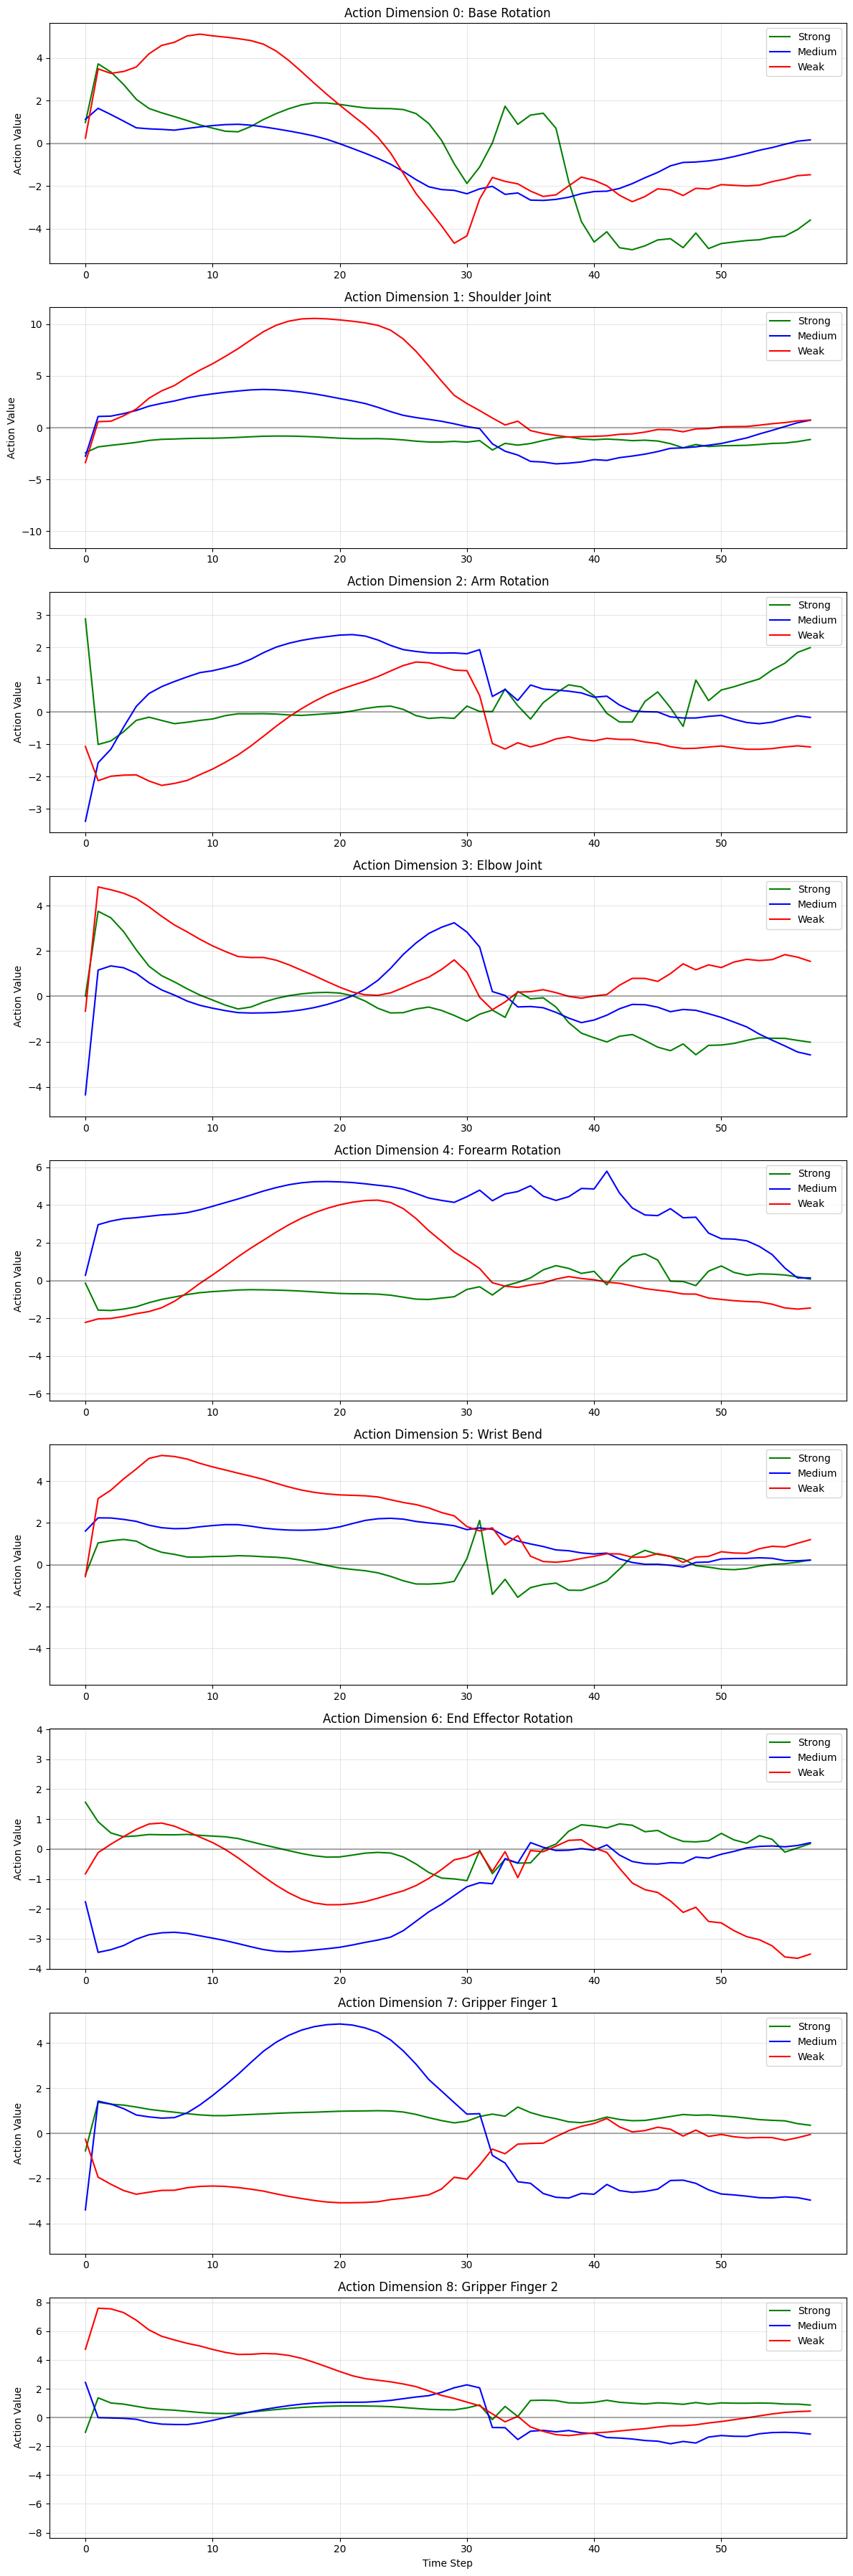

In [25]:
plot_action_trajectories(
    strong_obs_mu_list,
    labels=labels,
    actor_idx=actor_idx
)

In [26]:
strong_obs_clipped_mu_list = [
    mu_strong_original_clipped, 
    mu_medium_strong_obs_clipped, 
    mu_weak_strong_obs_clipped
]

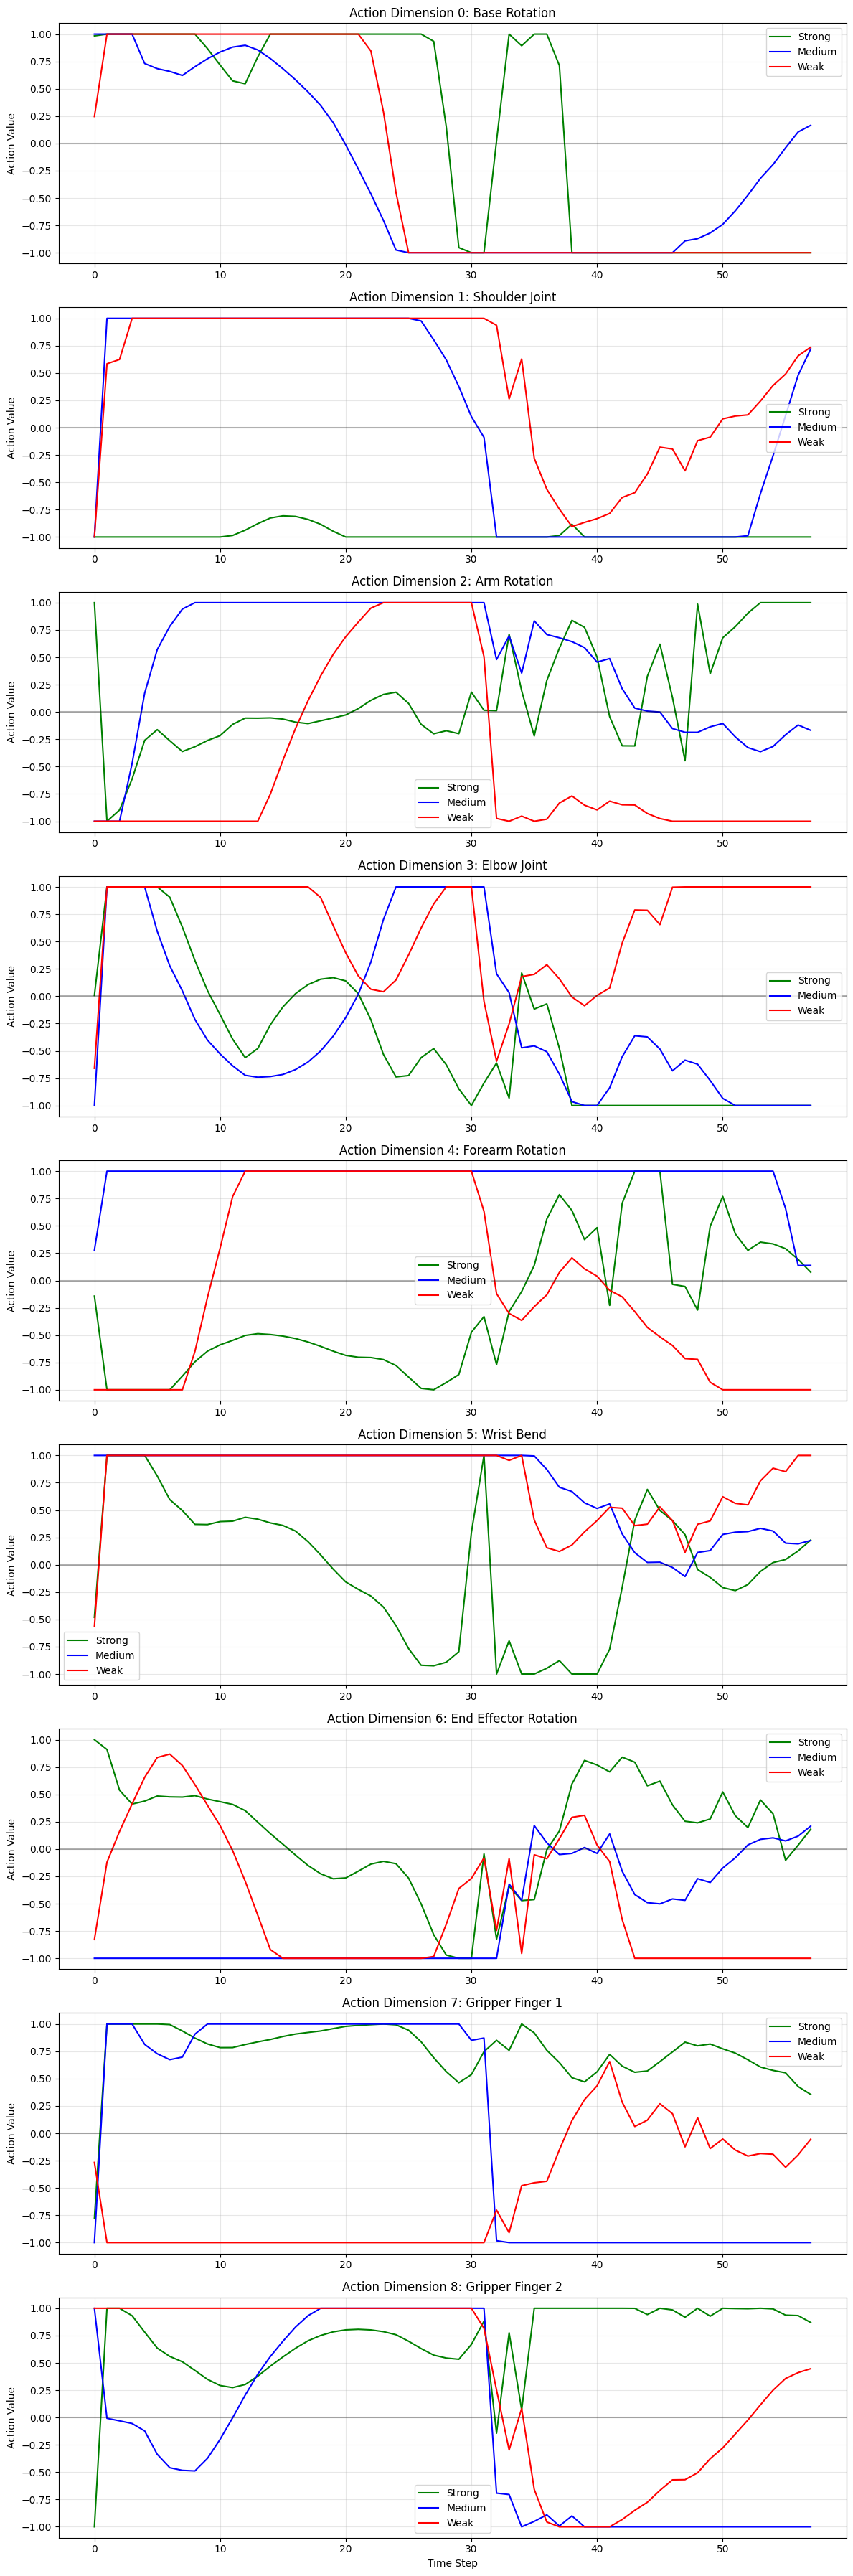

In [27]:
plot_action_trajectories(
    strong_obs_clipped_mu_list,
    labels=labels,
    actor_idx=actor_idx
)

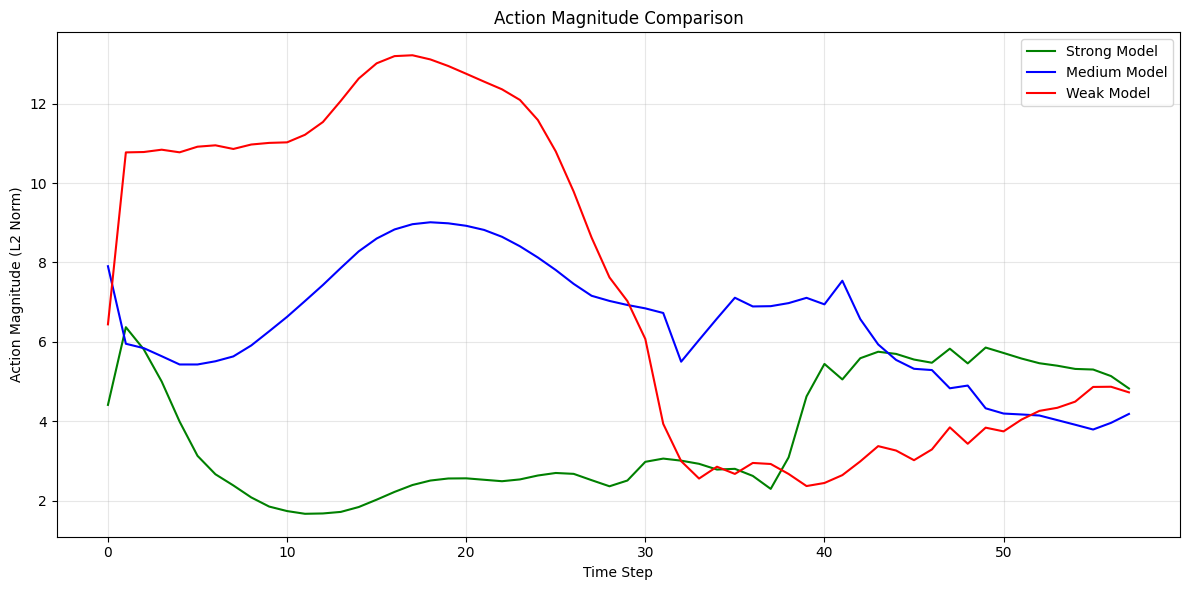

In [16]:
plot_action_magnitudes(mu_strong_original, mu_weak_strong_obs, mu_medium_strong_obs, batch_idx)

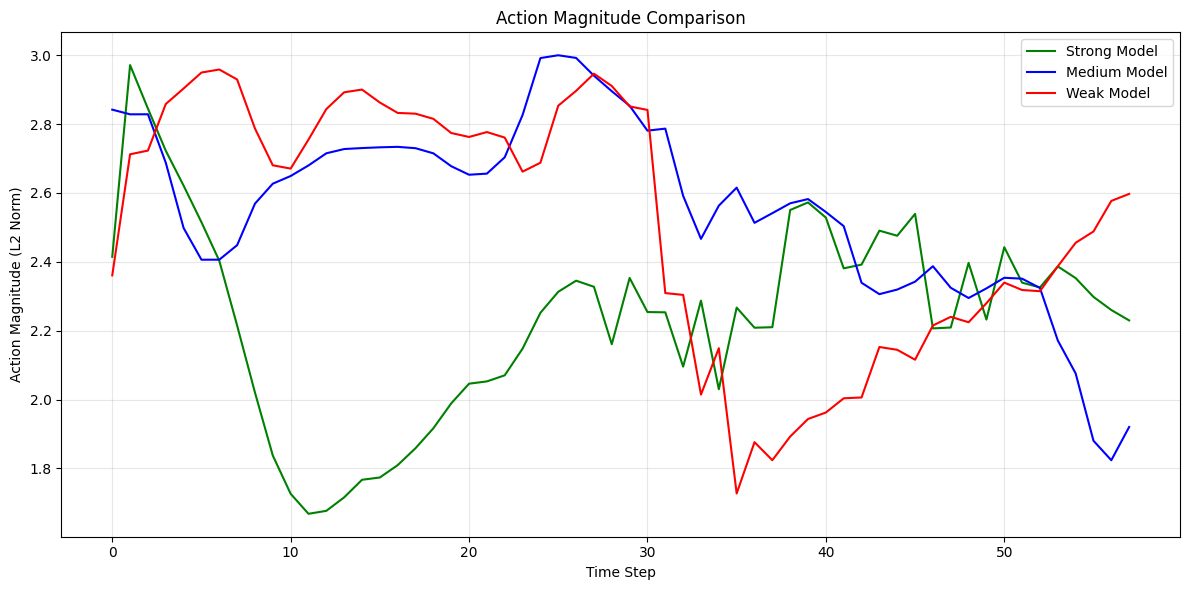

In [17]:
plot_action_magnitudes(
    mu_strong_original_clipped, 
    mu_weak_strong_obs_clipped, 
    mu_medium_strong_obs_clipped, 
    batch_idx
)

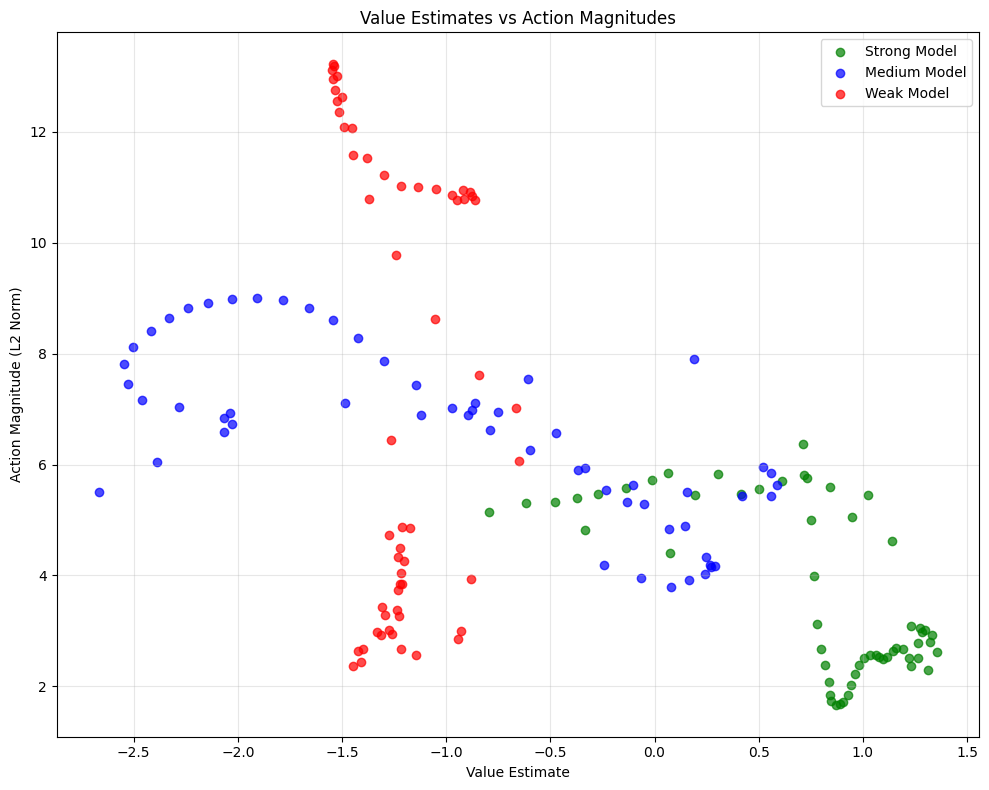

In [18]:
plot_value_vs_action(mu_strong_original, value_strong_original, 
                     mu_weak_strong_obs, value_weak_strong_obs,
                     mu_medium_strong_obs, value_medium_strong_obs, batch_idx)

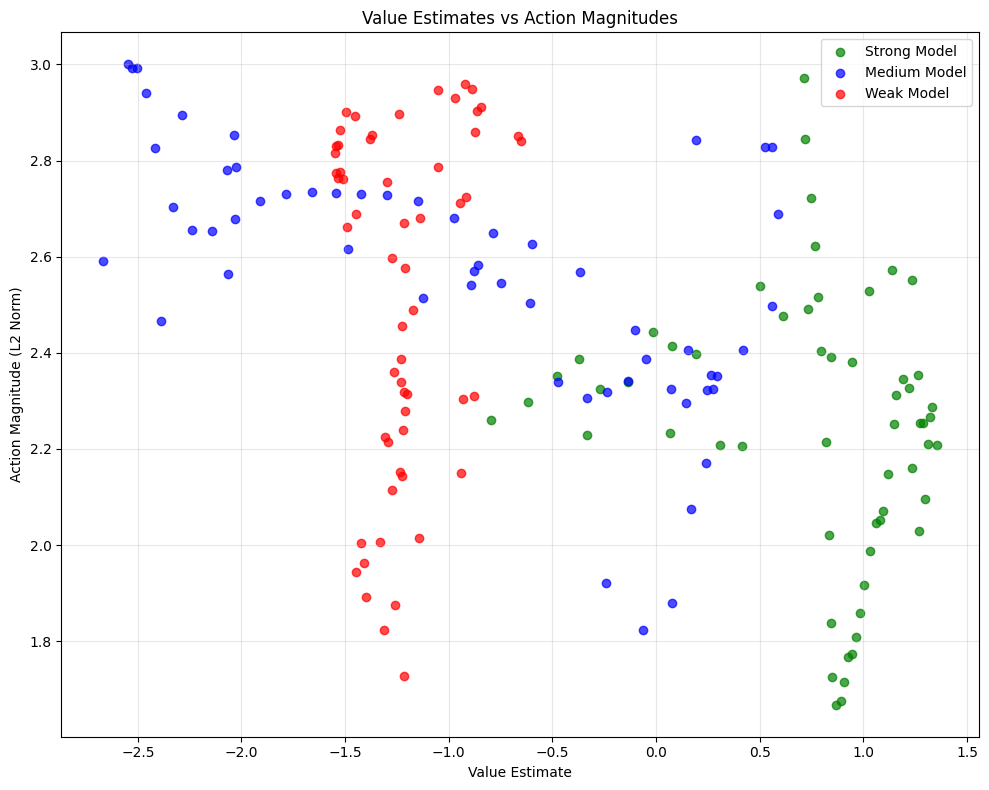

In [19]:
# Value vs Action Scatter Plot
plot_value_vs_action(mu_strong_original_clipped, value_strong_original, 
                     mu_weak_strong_obs_clipped, value_weak_strong_obs,
                     mu_medium_strong_obs_clipped, value_medium_strong_obs, batch_idx)

## Experiment 2

In [17]:
# Run strong model on weak observations
mu_strong_weak_obs, value_strong_weak_obs, _ = compute_model_outputs(
    strong_model, 
    obs_weak_original, 
    mu_weak_original, 
    value_weak_original
)

In [18]:
# Process outputs
mu_strong_weak_obs_clipped, value_strong_weak_obs_denorm = process_model_outputs(
    mu_strong_weak_obs, 
    value_strong_weak_obs, 
    strong_model
)

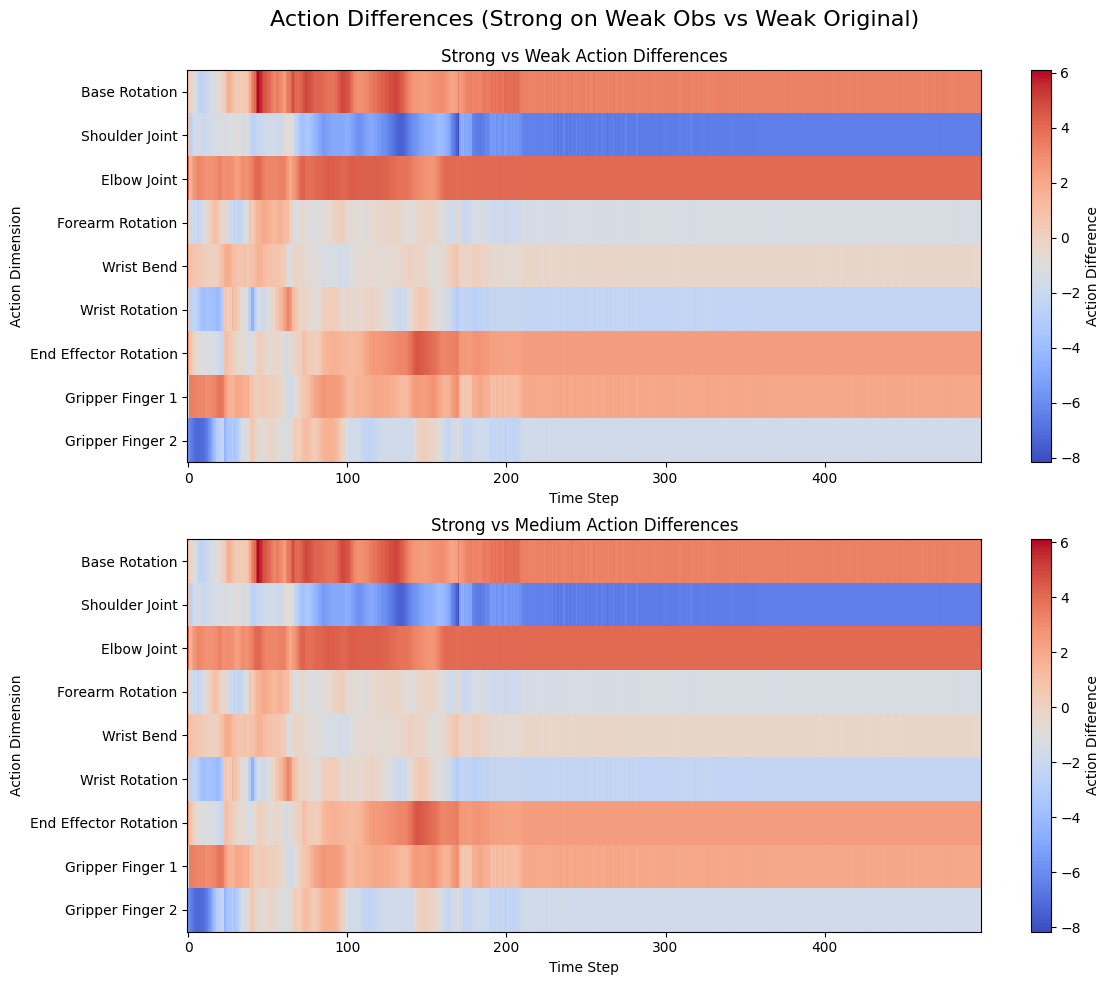

In [23]:
# 1. Action Dimension Heatmaps
# Compare strong model's actions on weak observations vs weak model's original actions
plot_action_heatmap(mu_strong_weak_obs, mu_weak_original, mu_weak_original, 
                    batch_idx=batch_idx, 
                    title="Action Differences (Strong on Weak Obs vs Weak Original)")

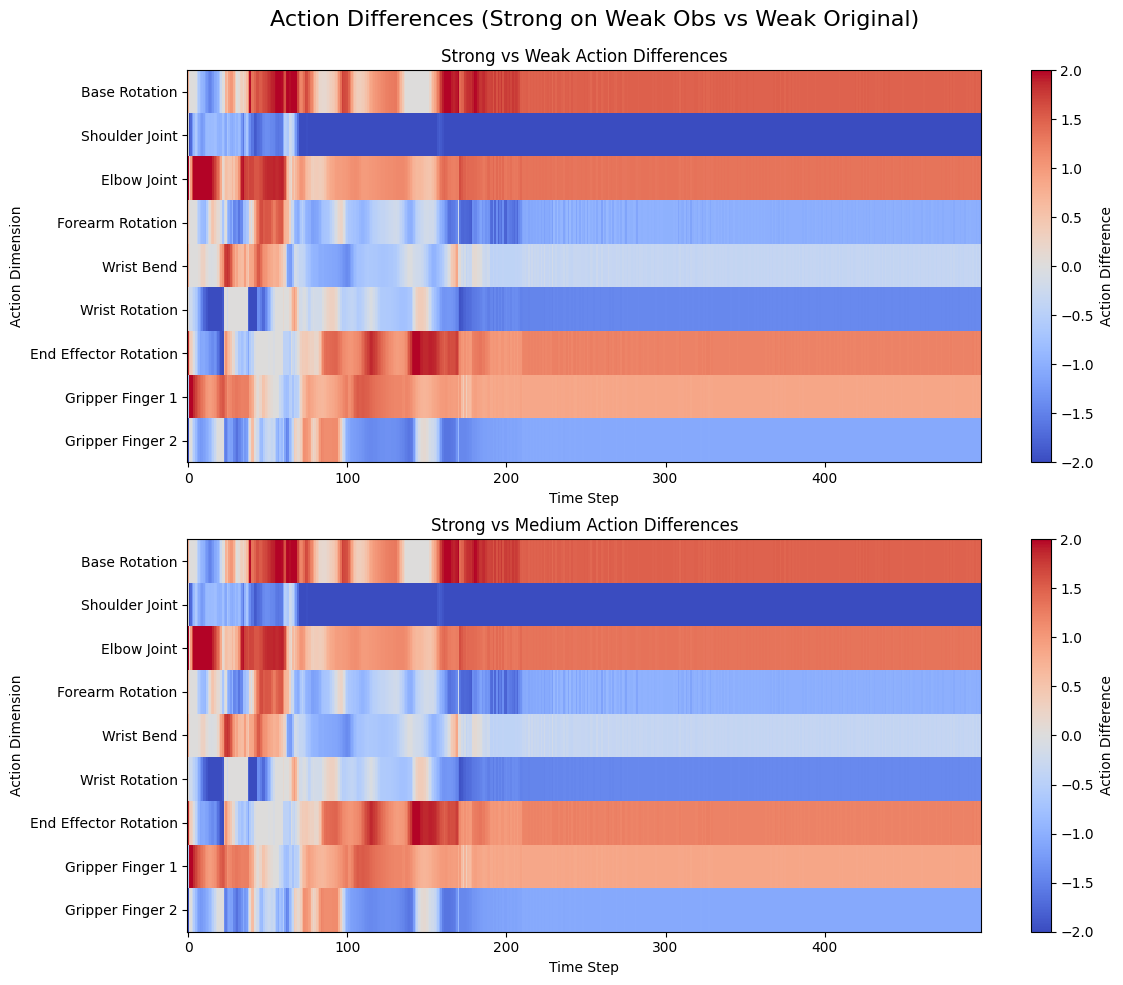

In [24]:
plot_action_heatmap(mu_strong_weak_obs_clipped, mu_weak_original_clipped, mu_weak_original_clipped, 
                    batch_idx=batch_idx, 
                    title="Action Differences (Strong on Weak Obs vs Weak Original)")

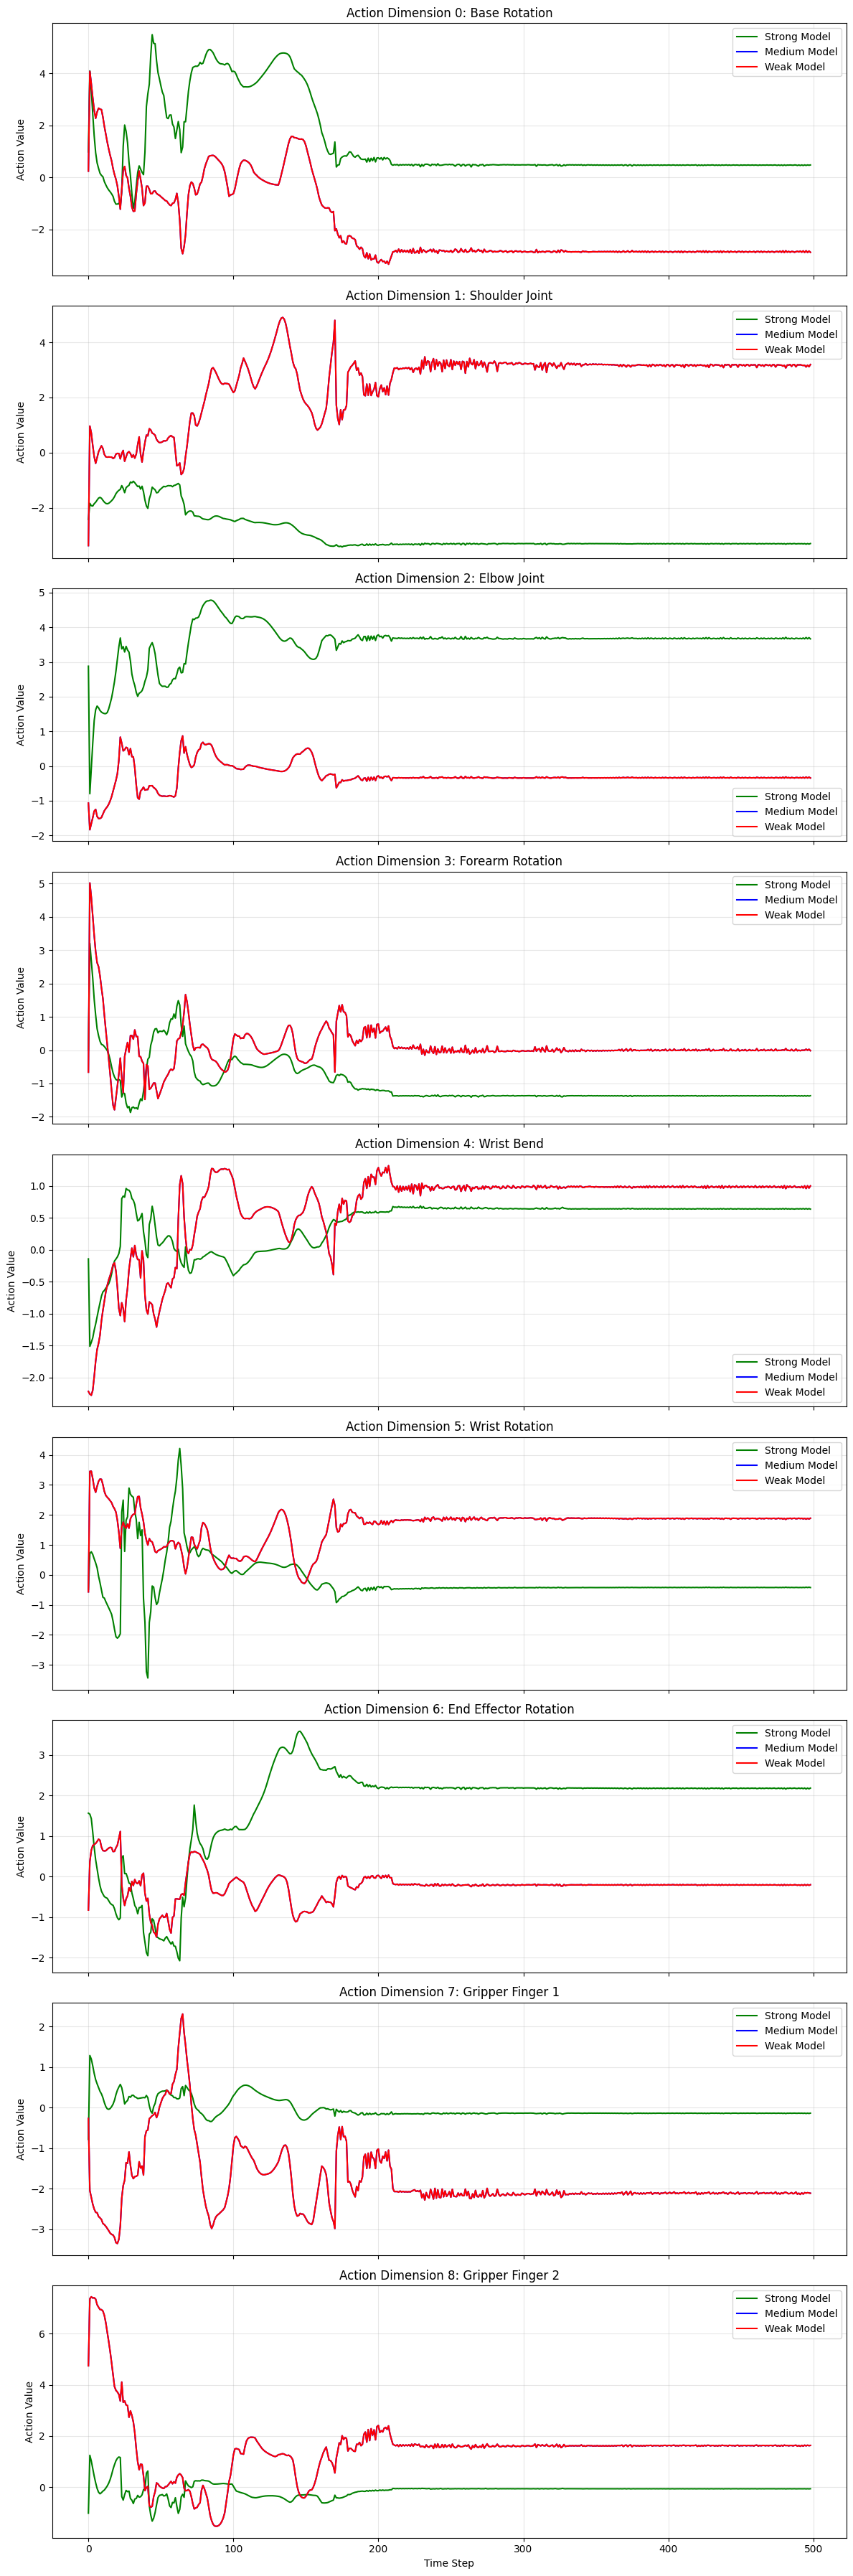

In [25]:
plot_action_trajectories(mu_strong_weak_obs, mu_weak_original, mu_weak_original, 
                         action_dims=list(range(9)), 
                         batch_idx=batch_idx)

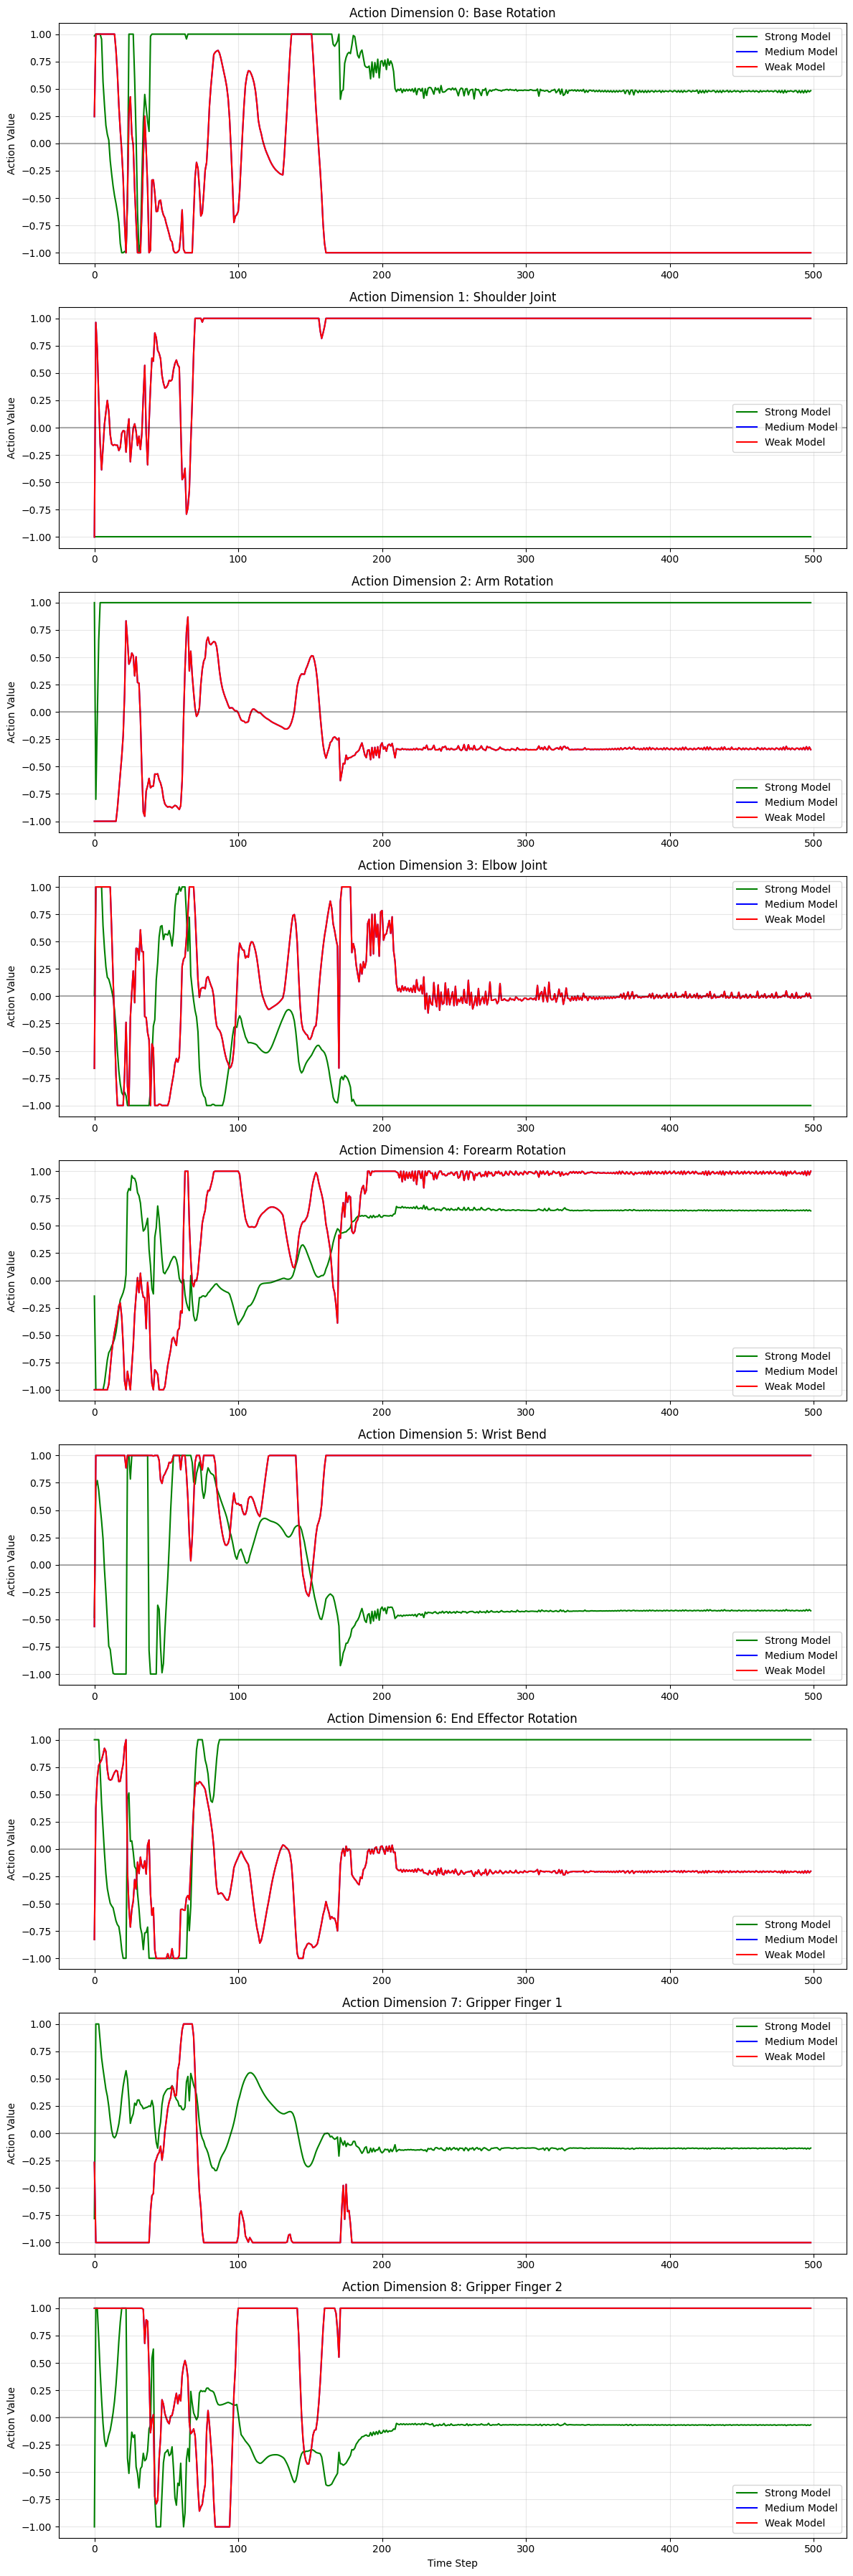

In [19]:
plot_action_trajectories(mu_strong_weak_obs_clipped, mu_weak_original_clipped, mu_weak_original_clipped, 
                         action_dims=list(range(9)), 
                         batch_idx=batch_idx)

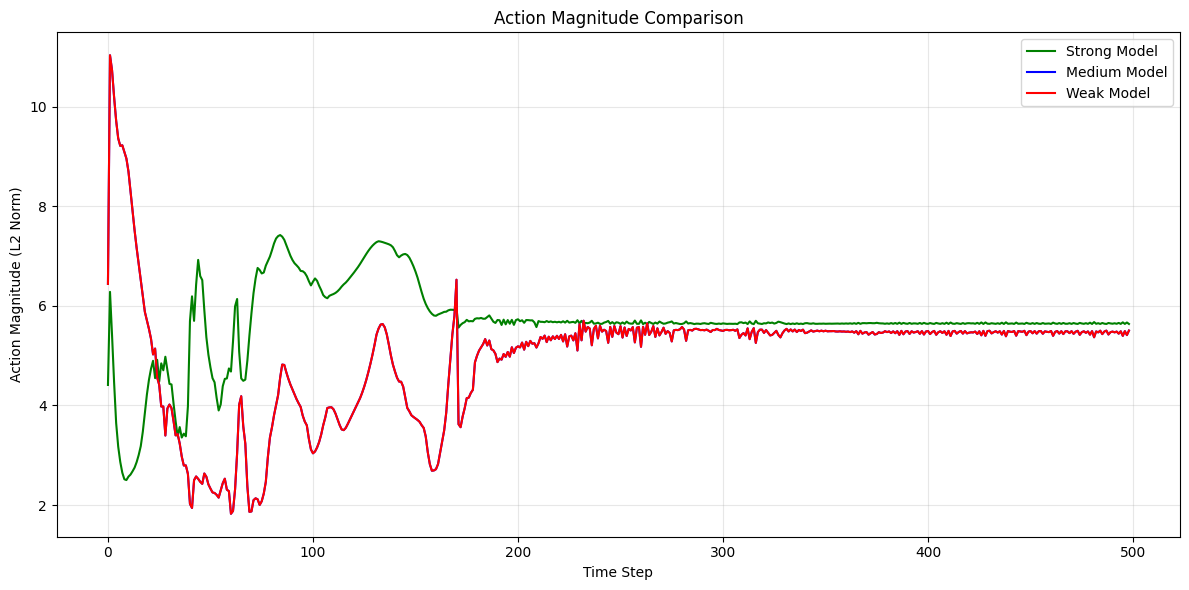

In [27]:
plot_action_magnitudes(mu_strong_weak_obs, mu_weak_original, mu_weak_original, 
                       batch_idx=batch_idx)

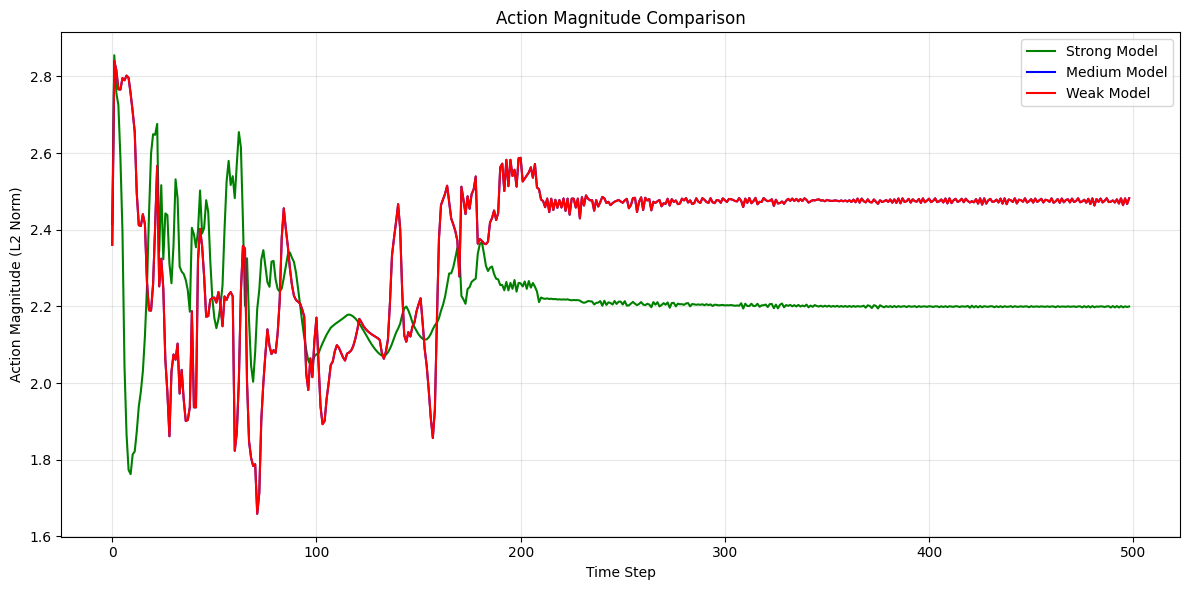

In [28]:
plot_action_magnitudes(mu_strong_weak_obs_clipped, mu_weak_original_clipped, mu_weak_original_clipped, 
                       batch_idx=batch_idx)

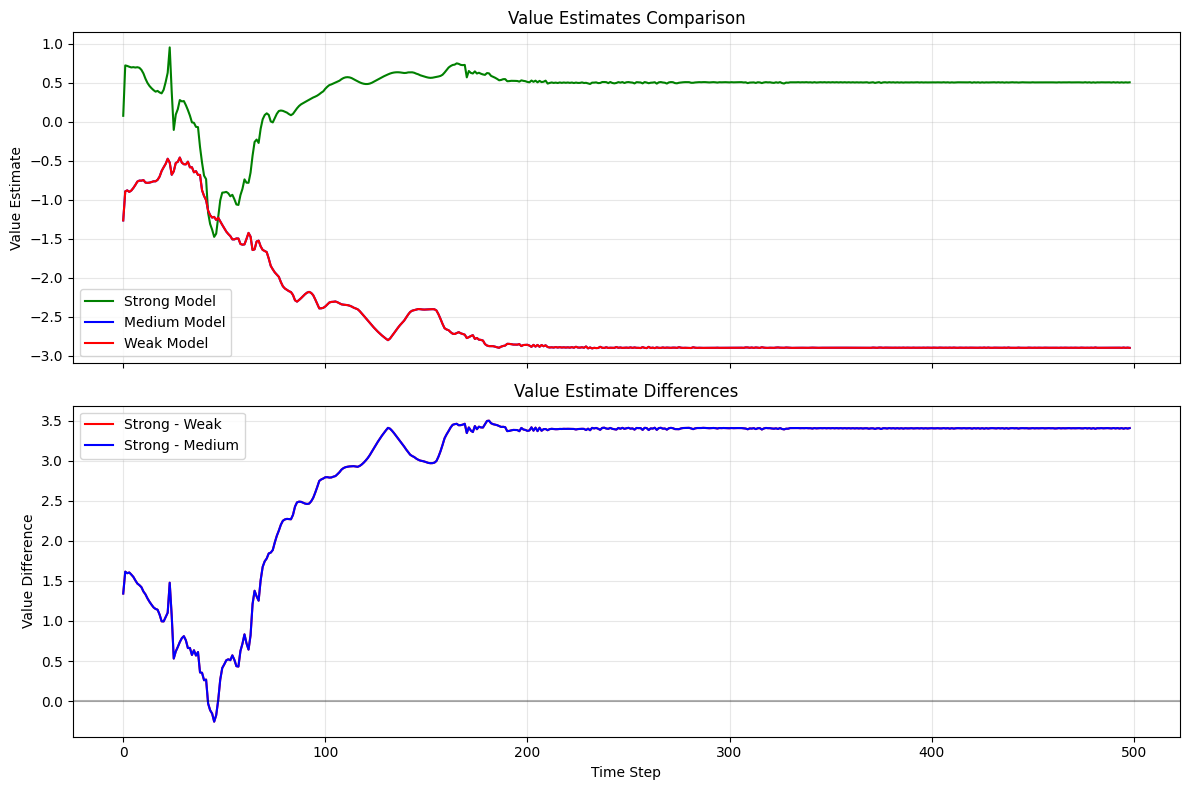

In [29]:
plot_value_comparison(value_strong_weak_obs, value_weak_original, value_weak_original, 
                      batch_idx=batch_idx)

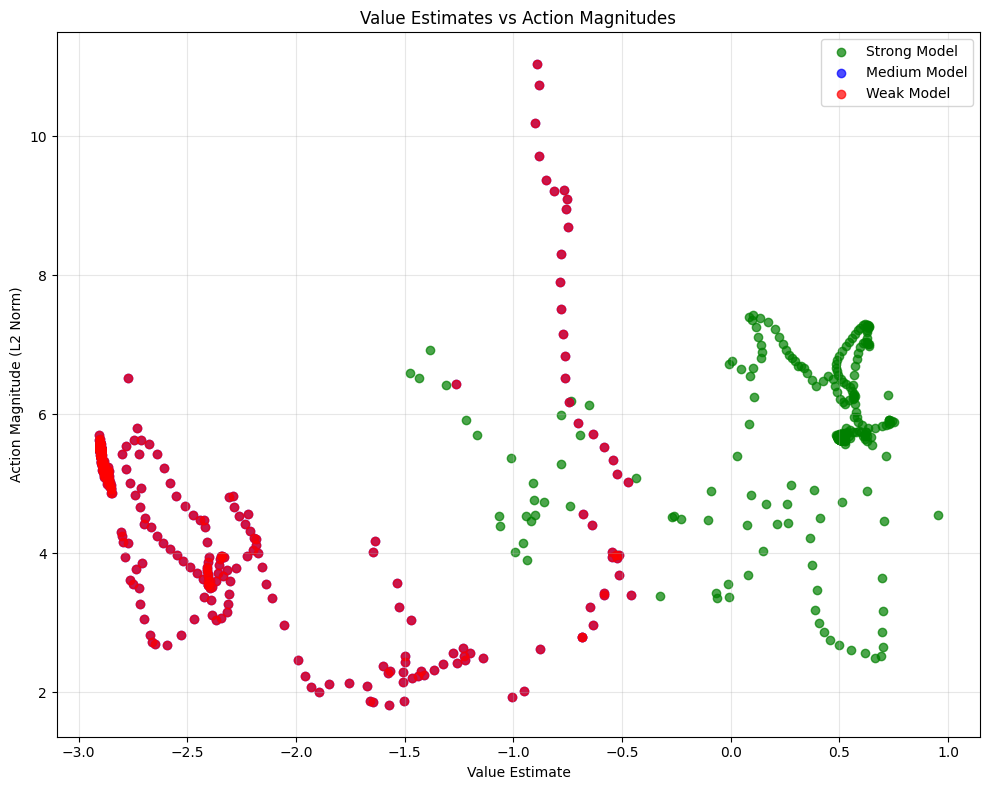

In [30]:
# 5. Value vs Action Scatter Plot
# See the relationship between value estimates and action magnitudes
plot_value_vs_action(mu_strong_weak_obs, value_strong_weak_obs, 
                     mu_weak_original, value_weak_original,
                     mu_weak_original, value_weak_original, 
                     batch_idx=batch_idx)

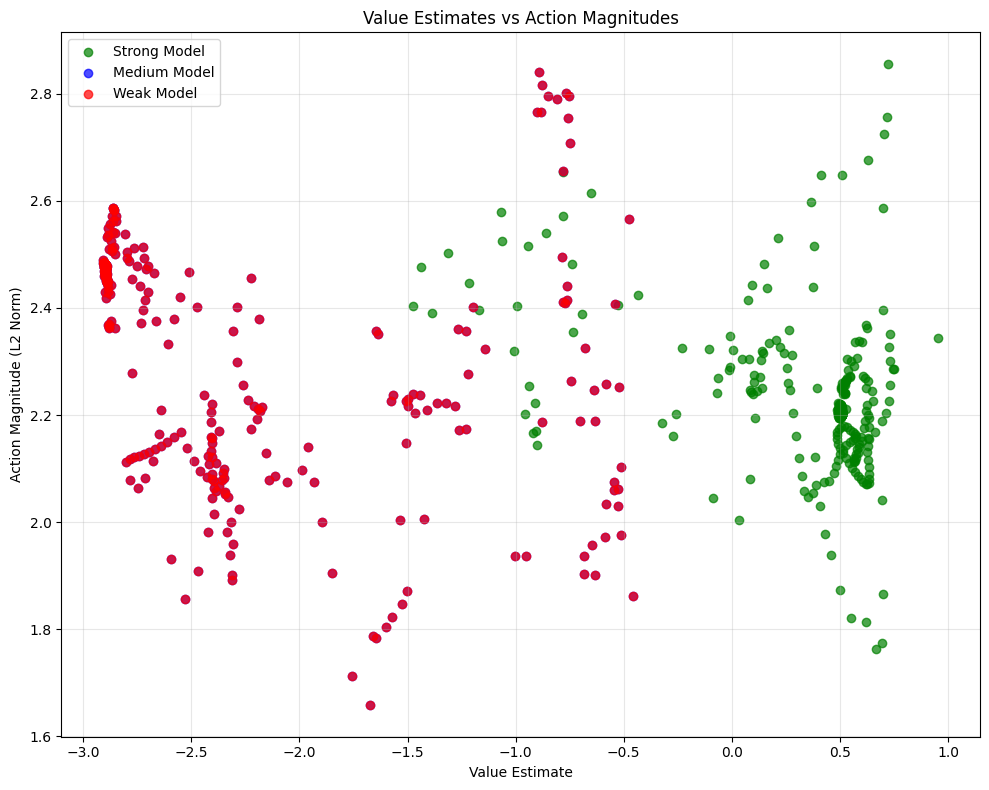

In [31]:
# 5. Value vs Action Scatter Plot
# See the relationship between value estimates and action magnitudes
plot_value_vs_action(mu_strong_weak_obs_clipped, value_strong_weak_obs, 
                     mu_weak_original_clipped, value_weak_original,
                     mu_weak_original_clipped, value_weak_original, 
                     batch_idx=batch_idx)